In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numba import njit
from scipy.optimize import curve_fit
import scipy.stats
plt.style.use('dark_background')

In [2]:
#@title Import data
#create a list of all the files in the folder
DIR = "../data/energia/LOB_ottobre21/LOB_ottobre21/"
lob_files =os.listdir(DIR)
lob_files.sort()
lst_order = []
for element in lob_files:
    # import data
    df = pd.read_csv(DIR+ element)
    df.fillna(0, inplace = True)

    # delete first two column and empty LOB
    df.drop(columns = ["Unnamed: 0", "key"], inplace = True)
    df.drop(df[df["AskPrice_0"] == 0].index.to_list(), inplace = True)
    df.drop(df[df["BidPrice_0"] == 0].index.to_list(), inplace = True)

    # scale price to dollar cent and add mid price and spread
    df["MidPrice"] = (df["BidPrice_0"] + df["AskPrice_0"]) / 2
    df["Spread"] = df["AskPrice_0"] - df["BidPrice_0"]

    # transform the column Datetime from string to datetime
    df["Datetime"]= pd.to_datetime(df["Datetime"])

    #create a new column that represent second to midnight 
    seconds = np.zeros(len(df))
    for i, date in enumerate(df["Datetime"]):
        seconds[i] = date.second + 60 * date.minute + 3600 * date.hour + \
                                    date.microsecond * 1e-6
    df["Time"] = seconds


    df = df.loc[df["Datetime"].dt.day != 27]
    
    lst_order.append(df)

clean_data = pd.concat(lst_order)
clean_data.reset_index(inplace = True, drop = True)

message = pd.read_csv("../data/energia/order/best_matching.csv",
                      index_col = 0)

message["DateTime"] = pd.to_datetime(message["DateTime"])
data = pd.concat([clean_data, message[["Price", "Volume", "Sign", "Quote", "Type"]]], axis = 1)

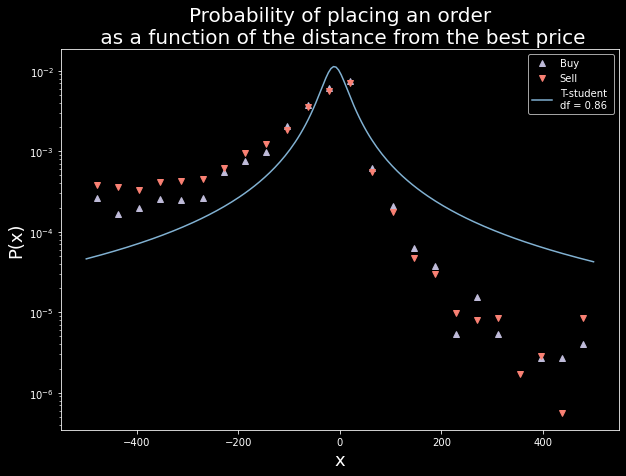

In [40]:
#@title Distribution order placement
fig, ax = plt.subplots(1, 1, figsize = (10,7))

bid_orders = data[(data["Sign"] == 1) & (data["Type"] != "Cancel")].index.to_numpy()
bid_orders[0] = 2

best_bid = data["BidPrice_0"].loc[bid_orders - 1].multiply(100). to_numpy()
bid_price =  data["Price"].loc[bid_orders].multiply(100).to_numpy()

log_distance =  bid_price - best_bid
n_b, bins_b, _ = plt.hist(log_distance, density = True, bins = np.linspace(-500 , 500 , 25), alpha = 0)

ask_orders = data[(data["Sign"] == -1) & (data["Type"] != "Cancel")].index.to_numpy()

best_ask = data["AskPrice_0"].loc[ask_orders - 1].multiply(100). to_numpy()
ask_price =  data["Price"].loc[ask_orders].multiply(100).to_numpy()

log_distance_a = best_ask - ask_price
n_a, bins_a, _ = plt.hist(log_distance_a, density = True, bins = np.linspace(-500 , 500 , 25), alpha = 0)


x_a = (bins_a[1:] + bins_a[:-1]) / 2
x_b = (bins_b[1:] + bins_b[:-1]) / 2
plt.plot(x_b, n_a, ls= "", marker = "^", label = "Buy")
plt.plot(x_a, n_b, ls= "", marker = "v", label = "Sell")

xx = np.linspace(-500,500,200)
df, l, s = scipy.stats.t.fit(log_distance_a)
plt.plot(xx, scipy.stats.t.pdf(xx, df, loc = l, scale = s), label =f"T-student \ndf = {df:.2f}")

plt.ylabel("P(x)", fontsize = 18)
plt.xlabel("x", fontsize = 18)
plt.title("Probability of placing an order\n as a function of the distance from the best price", fontsize= 20)
plt.yscale("log")
plt.legend()

plt.show()

In [41]:
import levy

In [38]:
levy.fit_levy(log_distance_a, alpha = 1)

(par=0, alpha=1.00, beta=-0.78, mu=-14.71, sigma=26.80, 219023.43165854402)

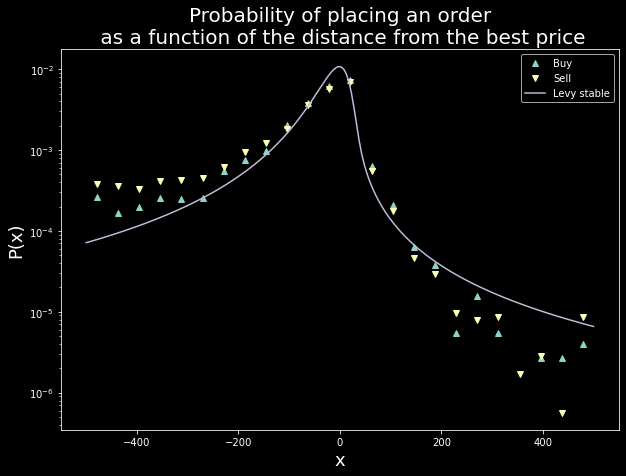

In [43]:
#@title Levy stable
fig, ax = plt.subplots(1, 1, figsize = (10,7))

plt.plot(x_b, n_a, ls= "", marker = "^", label = "Buy")
plt.plot(x_a, n_b, ls= "", marker = "v", label = "Sell")

xx = np.linspace(-500,500,200)

plt.ylabel("P(x)", fontsize = 18)
plt.xlabel("x", fontsize = 18)
plt.title("Probability of placing an order\n as a function of the distance from the best price", fontsize= 20)
plt.yscale("log")


plt.plot(xx, scipy.stats.levy_stable.pdf(xx, 1, -0.78 , loc = l, scale = s), label =f"Levy stable", alpha= 1)
plt.yscale("log")
plt.legend()
plt.show()


In [44]:
scipy.stats.skewcauchy.fit(log_distance_a)

(-0.6109171782916127, -0.03156506435554055, 24.9522346201858)

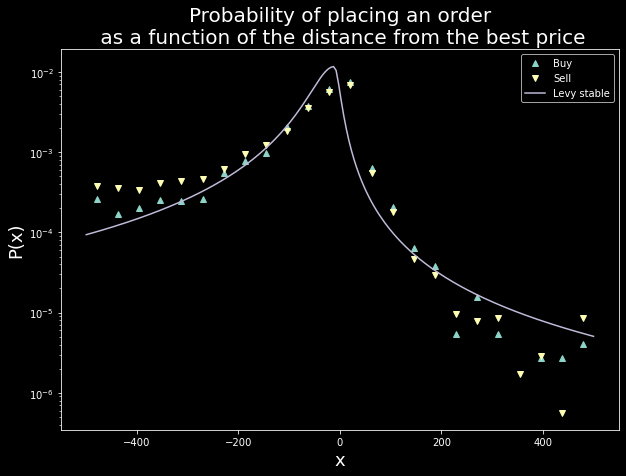

In [46]:
#@title Levy stable
fig, ax = plt.subplots(1, 1, figsize = (10,7))

plt.plot(x_b, n_a, ls= "", marker = "^", label = "Buy")
plt.plot(x_a, n_b, ls= "", marker = "v", label = "Sell")

xx = np.linspace(-500,500,200)

plt.ylabel("P(x)", fontsize = 18)
plt.xlabel("x", fontsize = 18)
plt.title("Probability of placing an order\n as a function of the distance from the best price", fontsize= 20)
plt.yscale("log")


plt.plot(xx, scipy.stats.skewcauchy.pdf(xx, -0.61 , loc = l, scale = s), label =f"Levy stable", alpha= 1)
plt.yscale("log")
plt.legend()
plt.show()
